# Cube-Net ConvLSTM (Cross) Training Environment
This notebooks contains the setup and training of the convolutional LSTM network for the Cube-Net project. More specifically, this notebook contains the training environment for the cross solving network.

In [1]:
from generate_batch import BatchGenerator

batch_generator = BatchGenerator(batch_size = 2)

batch, scrambles = batch_generator()

Compiling the scrambler Rust program in release mode...
Compilation successful.


    Finished release [optimized] target(s) in 0.05s


In [2]:
print(f'Batch shape is {batch.shape}')
print(f'Scrambles are {len(scrambles)}')

Batch shape is torch.Size([2, 5, 5, 5])
Scrambles are 2


Here is a simple visualization of the cube data.

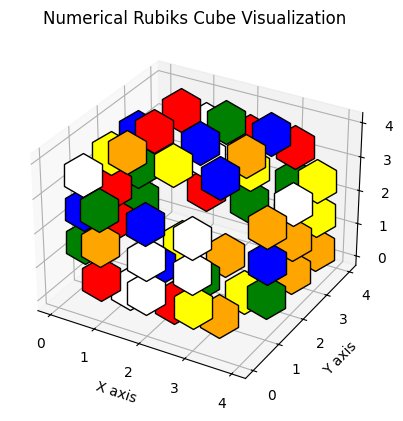

In [3]:
from plot_rubiks import Plot

plot = Plot()

plot.show_rubiks_(batch[0].numpy())

In [4]:
from check_solved import Check

check = Check()

Compiling the solution_verifier Rust program in release mode...


   Compiling solution_verifier v0.1.0 (/home/holindauer/Projects/Cube-Net/solution_verifier)
 --> src/parse.rs:6:5
  |
6 | use crate::moves;
  |     ^^^^^^^^^^^^
  |
  = note: `#[warn(unused_imports)]` on by default



Compilation successful.


    Finished release [optimized] target(s) in 0.47s


In [5]:
check.is_solved(scrambles[0], "")

0